In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from utils import LABEL_MAPPING, score_submission

plt.rcParams['figure.figsize'] = [12, 5]
sns.set()

INVERSE_LABEL_MAPPING = {v: k for k, v in LABEL_MAPPING.items()}
LABELS = list(LABEL_MAPPING.keys())


def add_preds_column_from_logits(df):
    df.loc[:, 'predicted_stance'] = df[['logit_0', 'logit_1', 'logit_2', 'logit_3']].values.argmax(axis=1)
    df.replace({'Stance': INVERSE_LABEL_MAPPING, 'predicted_stance': INVERSE_LABEL_MAPPING}, inplace=True)

### Hyperparameters tuning
I trained 3 models with different hyperparameters:

| Model | Learning rate | Use class weights |
|-------|---------------|-------------------|
| 1     | 1e-5          | True              | 
| 2     | 1e-5          | False             |
| 3     | 1e-4          | False             |

Models were trained with AdamW optimizer with weights decay of 0.1 for 10 epochs and the batch size was 16. 
The training was shorter than final training on the whole set due to the time and computational limitations.
The maximum length of the input was 512 -- this is the maximum lenght of the sequence DistilBERT can accept.
Although, it should cover most of the examples as a whole.

In [92]:
data_1 = pd.read_csv('results/train-val-2021-01-17T22:28:28-base/predictions.csv')
data_2 = pd.read_csv('results/train-val-2021-01-18T05:35:34-no-weighting/predictions.csv')
data_3 = pd.read_csv('results/train-val-2021-01-18T13:09:25-no-weighting_lr1e-4/predictions.csv')

data = [data_1, data_2, data_3]

for df in data:
    add_preds_column_from_logits(df)

In [93]:
data_1.head()

,Headline,articleBody,Stance,logit_0,logit_1,logit_2,logit_3,predicted_stance
0,Report: Christian Bale Just Bailed on the Stev...,"SEVEN girls, aged 13 to 15, have fallen pregna...",unrelated,-0.514103,-0.554900,-0.775034,0.869436,unrelated
1,"Michael Zehaf-Bibeau, slain Ottawa shooter, ha...",New York (CNN) -- When war reporter James Fole...,unrelated,0.592118,-0.744063,-0.590133,-0.869240,agree
2,Audio recording allegedly captures moment Mich...,Could a newly released audio provide more clue...,discuss,-0.981171,-0.694364,1.834086,-1.789990,discuss
3,Michael Phelps’ alleged girlfriend says she wa...,Protesters march in support of the girls kidna...,unrelated,-1.061492,-0.206372,0.666463,-0.426519,discuss
4,DHS: GOP Rep.’s Claim ISIS Members Caught at U...,"LAS VEGAS -- The person behind the $300,000 di...",unrelated,-0.319150,-1.067749,-0.648278,1.276031,unrelated


### Confusion matrices

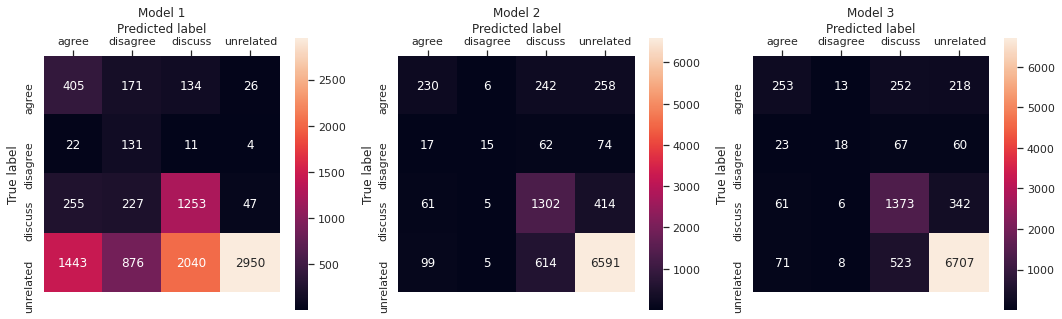

In [94]:
cms = [confusion_matrix(df['Stance'], df['predicted_stance']) for df in data]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (ax, cm) in enumerate(zip(axes, cms)):
    sns.heatmap(pd.DataFrame(cm, columns=LABELS, index=LABELS), annot=True, fmt='d', ax=ax, square=True)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_title(f"Model {i + 1}")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
plt.show()

### Metrics

In [95]:
for i, df in enumerate(data):
    print(f"----- MODEL {i + 1} -----")
    print(classification_report(df['Stance'], df['predicted_stance']))
    print(f"FNC score:\t{score_submission(df['Stance'], df['predicted_stance'])}\n\n")

----- MODEL 1 -----
              precision    recall  f1-score   support

       agree       0.19      0.55      0.28       736
    disagree       0.09      0.78      0.17       168
     discuss       0.36      0.70      0.48      1782
   unrelated       0.97      0.40      0.57      7309

    accuracy                           0.47      9995
   macro avg       0.41      0.61      0.38      9995
weighted avg       0.79      0.47      0.53      9995

FNC score:	2731.5


----- MODEL 2 -----
              precision    recall  f1-score   support

       agree       0.57      0.31      0.40       736
    disagree       0.48      0.09      0.15       168
     discuss       0.59      0.73      0.65      1782
   unrelated       0.90      0.90      0.90      7309

    accuracy                           0.81      9995
   macro avg       0.63      0.51      0.53      9995
weighted avg       0.81      0.81      0.81      9995

FNC score:	3293.0


----- MODEL 3 -----
              precision    rec

From metrics and confusion matrix we can see that Model 1 (the one with class weights included in the loss function) performed the worst.
It detects more `agree` and `disagree` examples than the rest of the models, but at the cost of huge amount of false positives.
There isn't much difference between Models 2 and 3. The latter is slighty better in almost all metrics, but one might expect that because
of the higher learning rate.

Models 2 and 3 differ in learning rate -- the first one was trained with step size 2 times higher.
As a final set of hyperparameters I've chosen the ones from Model 3 and extended the training to 20 epochs. After 10 epochs learning
rate was decreased by half.

### Final model

Final model was trained on the whole training dataset and predictions below were made on the official test set. However, this test set
is not the same as the test set used in the competition 4 years ago (it contains less examples). It was downloaded from the official FNC repository
(https://github.com/FakeNewsChallenge/fnc-1 -- files _competition_test_*.csv_) where one can find the test set used at the competition,
but it is unlabeled. Therefore, _FNC score_ cannot be directly compared to the official scores of the competition winners.

In [101]:
data_test = pd.read_csv("results/train-2021-01-18T23:03:01-lr1e-4_scheduler/predictions.csv")
add_preds_column_from_logits(data_test)

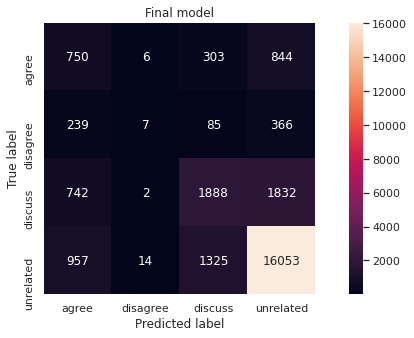

In [102]:
cm = confusion_matrix(data_test['Stance'], data_test['predicted_stance'])
sns.heatmap(pd.DataFrame(cm, columns=LABELS, index=LABELS), annot=True, fmt='d', square=True)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.title(f"Final model")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [104]:
print(classification_report(data_test['Stance'], data_test['predicted_stance']))
print(f"FNC score:\t{score_submission(data_test['Stance'], data_test['predicted_stance'])}\n\n")

              precision    recall  f1-score   support

       agree       0.28      0.39      0.33      1903
    disagree       0.24      0.01      0.02       697
     discuss       0.52      0.42      0.47      4464
   unrelated       0.84      0.87      0.86     18349

    accuracy                           0.74     25413
   macro avg       0.47      0.43      0.42     25413
weighted avg       0.73      0.74      0.73     25413

FNC score:	7002.5




On the test set the model performed worse than on the validation set. Both accuracy (although it is not very useful metric in this case) and macro F1 score are lower. Classifier handles `unrelated` class quite well, but it is not the class we want to detect.